In [28]:
import os
os.getcwd()
os.chdir("G:/OneDrive/casa0010dissertation/00_06 jaipur code_mgwr")

In [29]:
import numpy as np
import pandas as pd

# 1 Create 100m resolution rasters and Grid

In [30]:
import rasterio

#3 raster file paths
raster_files = [
    'data/cleaned/resampled_100m/Illuminated_Residential_Volume_100m.tif',           # illumination volume
    'data/cleaned/resampled_100m/Residential_Light_Intensity_10m_100m.tif',     # light intensity
    'data/cleaned/resampled_100m/combined_poi_kde_1600m_residential_100m.tif'              # POI kernel density
]

# Check spatial parameters for each raster
def check_raster_info(file_path):
    with rasterio.open(file_path) as src:
        return {
            'file': file_path.split('/')[-1],
            'transform': src.transform,
            'crs': src.crs,
            'bounds': src.bounds,
            'shape': src.shape,
            'pixel_size': (src.transform[0], abs(src.transform[4])),  # (x_size, y_size)
            'origin': (src.bounds.left, src.bounds.top)  # Top-left corner coordinates
        }

# Check all rasters
raster_info = []
for file in raster_files:
    info = check_raster_info(file)
    raster_info.append(info)

# Print detailed information
for info in raster_info:
    print(f"\n=== {info['file']} ===")
    print(f"Pixel size: {info['pixel_size']}")
    print(f"Coordinate system: {info['crs']}")
    print(f"Bounds: {info['bounds']}")
    print(f"Shape: {info['shape']}")
    print(f"Affine transform: {info['transform']}")


=== Illuminated_Residential_Volume_100m.tif ===
Pixel size: (100.0, 100.0)
Coordinate system: EPSG:32643
Bounds: BoundingBox(left=568320.0, bottom=2961490.0, right=590620.0, top=2989590.0)
Shape: (281, 223)
Affine transform: | 100.00, 0.00, 568320.00|
| 0.00,-100.00, 2989590.00|
| 0.00, 0.00, 1.00|

=== Residential_Light_Intensity_10m_100m.tif ===
Pixel size: (100.0, 100.0)
Coordinate system: EPSG:32643
Bounds: BoundingBox(left=568320.0, bottom=2961490.0, right=590620.0, top=2989590.0)
Shape: (281, 223)
Affine transform: | 100.00, 0.00, 568320.00|
| 0.00,-100.00, 2989590.00|
| 0.00, 0.00, 1.00|

=== combined_poi_kde_1600m_residential_100m.tif ===
Pixel size: (99.65089520390208, 99.93849810134725)
Coordinate system: EPSG:32643
Bounds: BoundingBox(left=567326.3241777108, bottom=2960497.836030203, right=591541.491712259, top=2990579.3239587084)
Shape: (301, 243)
Affine transform: | 99.65, 0.00, 567326.32|
| 0.00,-99.94, 2990579.32|
| 0.00, 0.00, 1.00|


## 1.1 resample and clip 3 data

Light and volume has same grid, so only need to align poi.

In [31]:
import geopandas as gpd
import rasterio
import rasterio.mask
from rasterio.warp import reproject, Resampling
import numpy as np
import os

# Create output directory
os.makedirs('data/cleaned', exist_ok=True)

# Load city boundary
city_boundary = gpd.read_file('data/raw/JMC_union.geojson')

# Check boundary info
print("City boundary info:")
print(f"CRS: {city_boundary.crs}")
print(f"Bounds: {city_boundary.total_bounds}")
print(f"Number of features: {len(city_boundary)}")

City boundary info:
CRS: EPSG:32643
Bounds: [ 568325.71944039 2961497.6341498   590541.50001579 2989580.08202327]
Number of features: 1


In [32]:
# Use illumination raster as reference for alignment
with rasterio.open('data/cleaned/resampled_100m/Illuminated_Residential_Volume_100m.tif') as reference:
    ref_transform = reference.transform
    ref_crs = reference.crs
    ref_shape = reference.shape

# Resample POI raster to match reference grid
with rasterio.open('data/cleaned/resampled_100m/combined_poi_kde_1600m_residential_100m.tif') as poi_src:
    # Create aligned array
    aligned_poi = np.empty(ref_shape, dtype=poi_src.dtypes[0])

    # Reproject to match reference grid
    reproject(
        source=rasterio.band(poi_src, 1),
        destination=aligned_poi,
        src_transform=poi_src.transform,
        src_crs=poi_src.crs,
        dst_transform=ref_transform,
        dst_crs=ref_crs,
        resampling=Resampling.bilinear
    )

    # Save resampled POI raster (temporary file)
    with rasterio.open('temp_aligned_poi.tif', 'w',
                       driver='GTiff', height=ref_shape[0], width=ref_shape[1],
                       count=1, dtype=aligned_poi.dtype, crs=ref_crs,
                       transform=ref_transform, nodata=0) as dst:
        dst.write(aligned_poi, 1)

print("POI raster resampled to match other two!")

POI raster resampled to match other two!


In [33]:
# Now all three rasters are aligned - crop them all
all_rasters = [
    'data/cleaned/resampled_100m/Illuminated_Residential_Volume_100m.tif',
    'data/cleaned/resampled_100m/Residential_Light_Intensity_10m_100m.tif',
    'temp_aligned_poi.tif'  # The resampled POI raster
]

output_names = [
    'illum_vol_cropped.tif',
    'light_intensity_cropped.tif',
    'poi_kde_cropped.tif'
]

cropped_files = []

for i, raster_file in enumerate(all_rasters):
    with rasterio.open(raster_file) as src:
        # Crop raster with city boundary
        out_image, out_transform = rasterio.mask.mask(
            src, city_boundary.geometry, crop=True, nodata=0
        )

        # Update metadata
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "nodata": 0
        })

        # Save cropped raster to data/cleaned
        output_file = f"data/cleaned/{output_names[i]}"
        with rasterio.open(output_file, "w", **out_meta) as dest:
            dest.write(out_image)

        cropped_files.append(output_file)
        print(f"Cropped and saved: {output_file}")

# Clean up temporary file
os.remove('temp_aligned_poi.tif')

Cropped and saved: data/cleaned/illum_vol_cropped.tif
Cropped and saved: data/cleaned/light_intensity_cropped.tif
Cropped and saved: data/cleaned/poi_kde_cropped.tif


In [34]:
# Check all three cropped rasters are perfectly aligned
cropped_rasters = [
    'data/cleaned/illum_vol_cropped.tif',
    'data/cleaned/light_intensity_cropped.tif',
    'data/cleaned/poi_kde_cropped.tif'
]

for raster_file in cropped_rasters:
    with rasterio.open(raster_file) as src:
        print(f"\n=== {raster_file} ===")
        print(f"Shape: {src.shape}")
        print(f"Pixel size: {(src.transform[0], abs(src.transform[4]))}")
        print(f"Transform: {src.transform}")
        print(f"Bounds: {src.bounds}")


=== data/cleaned/illum_vol_cropped.tif ===
Shape: (281, 223)
Pixel size: (100.0, 100.0)
Transform: | 100.00, 0.00, 568320.00|
| 0.00,-100.00, 2989590.00|
| 0.00, 0.00, 1.00|
Bounds: BoundingBox(left=568320.0, bottom=2961490.0, right=590620.0, top=2989590.0)

=== data/cleaned/light_intensity_cropped.tif ===
Shape: (281, 223)
Pixel size: (100.0, 100.0)
Transform: | 100.00, 0.00, 568320.00|
| 0.00,-100.00, 2989590.00|
| 0.00, 0.00, 1.00|
Bounds: BoundingBox(left=568320.0, bottom=2961490.0, right=590620.0, top=2989590.0)

=== data/cleaned/poi_kde_cropped.tif ===
Shape: (281, 223)
Pixel size: (100.0, 100.0)
Transform: | 100.00, 0.00, 568320.00|
| 0.00,-100.00, 2989590.00|
| 0.00, 0.00, 1.00|
Bounds: BoundingBox(left=568320.0, bottom=2961490.0, right=590620.0, top=2989590.0)


## 1.2 Create 100m Grid Center Points

In [35]:
# Create 100m grid center points
with rasterio.open('data/cleaned/illum_vol_cropped.tif') as src:
    transform = src.transform
    shape = src.shape
    crs = src.crs

    # Create grid indices
    rows, cols = np.meshgrid(range(shape[0]), range(shape[1]), indexing='ij')

    # Get center coordinates
    xs, ys = rasterio.transform.xy(transform, rows.flatten(), cols.flatten(), offset='center')

    # Create points GeoDataFrame
    grid_gdf = gpd.GeoDataFrame(
        {
            'grid_id': range(len(xs)),
            'row': rows.flatten(),
            'col': cols.flatten()
        },
        geometry=gpd.points_from_xy(xs, ys),
        crs=crs
    )

print(f"Created {len(grid_gdf)} grid center points")

Created 62663 grid center points


In [36]:
grid_gdf.head(5)

,grid_id,row,col,geometry
0,0,0,0,POINT (568370 2989540)
1,1,0,1,POINT (568470 2989540)
2,2,0,2,POINT (568570 2989540)
3,3,0,3,POINT (568670 2989540)
4,4,0,4,POINT (568770 2989540)


# 2 Extract Values from Rasters to Grid

In [37]:
# Extract values from all three aligned rasters
# in this part, the extract vol value(sum in grid) is equal to its density as we use ha as unit and 100*100m grid is 1 ha.
raster_files = [
    'data/cleaned/illum_vol_cropped.tif',
    'data/cleaned/light_intensity_cropped.tif',
    'data/cleaned/poi_kde_cropped.tif'
]

column_names = ['illum_vol', 'light_intensity', 'poi_kde']

# Extract values using row/col indices (most efficient method)
for i, raster_file in enumerate(raster_files):
    with rasterio.open(raster_file) as src:
        # Read entire raster
        raster_data = src.read(1)

        # Extract values using row/col indices
        values = raster_data[grid_gdf['row'], grid_gdf['col']]

        # Add to grid dataframe
        grid_gdf[column_names[i]] = values

print("Raster values extracted successfully!")
print(f"Grid columns: {list(grid_gdf.columns)}")
print(f"Sample data:\n{grid_gdf[['grid_id'] + column_names].head()}")

Raster values extracted successfully!
Grid columns: ['grid_id', 'row', 'col', 'geometry', 'illum_vol', 'light_intensity', 'poi_kde']
Sample data:
   grid_id  illum_vol  light_intensity  poi_kde
0        0        0.0              0.0      0.0
1        1        0.0              0.0      0.0
2        2        0.0              0.0      0.0
3        3        0.0              0.0      0.0
4        4        0.0              0.0      0.0


In [38]:
grid_gdf.head(5)

,grid_id,row,col,geometry,illum_vol,light_intensity,poi_kde
0,0,0,0,POINT (568370 2989540),0.0,0.0,0.0
1,1,0,1,POINT (568470 2989540),0.0,0.0,0.0
2,2,0,2,POINT (568570 2989540),0.0,0.0,0.0
3,3,0,3,POINT (568670 2989540),0.0,0.0,0.0
4,4,0,4,POINT (568770 2989540),0.0,0.0,0.0


In [39]:
# Calculate the value ranges and mean for the specified columns
columns_to_check = ['illum_vol', 'light_intensity', 'poi_kde']
for col in columns_to_check:
    min_value = grid_gdf[col].min()
    max_value = grid_gdf[col].max()
    mean_value = grid_gdf[col].mean()
    print(f"{col} value range: Min = {min_value}, Max = {max_value}, Mean = {mean_value}")

illum_vol value range: Min = 0.0, Max = 3477.942626953125, Mean = 313.7272033691406
light_intensity value range: Min = 0.0, Max = 74.91223907470703, Mean = 6.7797136306762695
poi_kde value range: Min = 0.0, Max = 1.3284281230596662e-08, Mean = 8.219883662619054e-10


# 3 Load Ward Data and Assign Coefficients

In [40]:
# Load ward GeoDataFrame
ward_gdf = gpd.read_file('data/cleaned/ward_results_mgwr_03.geojson')

print(f"Ward data loaded: {len(ward_gdf)} wards")
print(f"Ward columns: {list(ward_gdf.columns)}")
print(f"Ward CRS: {ward_gdf.crs}")

# Ensure ward_gdf and grid_gdf have same CRS
if ward_gdf.crs != grid_gdf.crs:
    ward_gdf = ward_gdf.to_crs(grid_gdf.crs)
    print(f"Ward CRS converted to: {ward_gdf.crs}")

# Spatial join: assign ward coefficients to grid points
# Include 'Id' as the unique ward identifier
grid_with_wards = gpd.sjoin(
    grid_gdf,
    ward_gdf[['Id', 'Ward_No', 'POP', 'intercept', 'illum_vol_estimate',
              'light_intensity_estimate', 'poi_kde_estimate', 'geometry']],
    how='left',
    predicate='within'
)

# Check results
outside_wards = grid_with_wards['Id'].isna().sum()
print(f"Grid points outside wards: {outside_wards}")
print(f"Grid points with ward assignments: {len(grid_with_wards) - outside_wards}")

# Preview results
print(f"\nSample data with ward info:")
print(grid_with_wards[['grid_id', 'Id', 'Ward_No', 'illum_vol', 'light_intensity', 'poi_kde',
                       'intercept', 'illum_vol_estimate']].head())

# Check unique wards assigned
print(f"\nNumber of unique wards in grid: {grid_with_wards['Id'].nunique()}")
print(f"Ward ID range: {grid_with_wards['Id'].min()} to {grid_with_wards['Id'].max()}")

Ward data loaded: 251 wards
Ward columns: ['Id', 'Area', 'Ward_No', 'POP', 'DENS_PPH', 'NAME', 'assembly', 'jmc', 'X', 'Y', 'lon', 'lat', 'illum_vol_density', 'light_intensity', 'poi_kde', 'poi_kde_scaled', 'intercept', 'illum_vol_estimate', 'light_intensity_estimate', 'poi_kde_estimate', 'geometry']
Ward CRS: EPSG:32643
Grid points outside wards: 23759
Grid points with ward assignments: 38904

Sample data with ward info:
   grid_id  Id  Ward_No  illum_vol  light_intensity  poi_kde  intercept  \
0        0 NaN      NaN        0.0              0.0      0.0        NaN   
1        1 NaN      NaN        0.0              0.0      0.0        NaN   
2        2 NaN      NaN        0.0              0.0      0.0        NaN   
3        3 NaN      NaN        0.0              0.0      0.0        NaN   
4        4 NaN      NaN        0.0              0.0      0.0        NaN   

   illum_vol_estimate  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4  

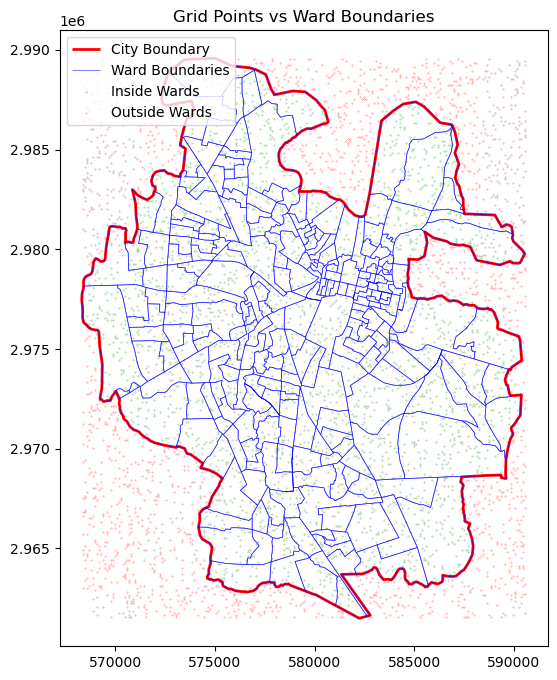

In [41]:
# Quick visualization to understand the gap
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot city boundary
city_boundary.boundary.plot(ax=ax, color='red', linewidth=2, label='City Boundary')

# Plot ward boundaries
ward_gdf.boundary.plot(ax=ax, color='blue', linewidth=0.5, alpha=0.7, label='Ward Boundaries')

# Plot grid points (sample for visibility)
grid_sample = grid_with_wards.sample(min(5000, len(grid_with_wards)))
inside = grid_sample[grid_sample['Id'].notna()]
outside = grid_sample[grid_sample['Id'].isna()]

inside.plot(ax=ax, color='green', markersize=0.1, alpha=0.5, label='Inside Wards')
outside.plot(ax=ax, color='red', markersize=0.1, alpha=0.5, label='Outside Wards')

plt.legend()
plt.title("Grid Points vs Ward Boundaries")
plt.show()

A problem happened here, some grid points are outside wards.It is because I use bounding box to crop the raster data.So I will filtered the data with city now.

In [42]:
# Clean up any existing spatial join columns first
cleanup_columns = ['index_right', 'index_left']
for col in cleanup_columns:
    if col in grid_with_wards.columns:
        grid_with_wards = grid_with_wards.drop(col, axis=1)
        print(f"Removed existing column: {col}")

print("Before filtering:")
print(f"Total grid points: {len(grid_with_wards)}")
print(f"Points outside wards: {grid_with_wards['Id'].isna().sum()}")

# Spatial join with city boundary - include points ON the boundary too
grid_in_city = gpd.sjoin(
    grid_with_wards,
    city_boundary[['geometry']],
    how='inner',  # Only keep matched points
    predicate='intersects'  # Include points inside OR on boundary
)

# Drop the extra index column from spatial join
if 'index_right' in grid_in_city.columns:
    grid_in_city = grid_in_city.drop('index_right', axis=1)

print("\nAfter filtering to city boundary:")
print(f"Grid points in city (including boundary): {len(grid_in_city)}")
print(f"Points outside wards (should be much less): {grid_in_city['Id'].isna().sum()}")

# Update our working dataframe
grid_with_wards = grid_in_city.copy()

# Check remaining unassigned points
remaining_outside = grid_with_wards['Id'].isna().sum()
if remaining_outside > 0:
    print(f"\nWill assign {remaining_outside} remaining points to nearest wards...")

Removed existing column: index_right
Before filtering:
Total grid points: 62663
Points outside wards: 23759

After filtering to city boundary:
Grid points in city (including boundary): 38906
Points outside wards (should be much less): 2

Will assign 2 remaining points to nearest wards...


In [43]:
# Handle the remaining 2 points outside wards
outside_points = grid_with_wards[grid_with_wards['Id'].isna()].copy()

if len(outside_points) > 0:
    print(f"Assigning {len(outside_points)} points to nearest wards...")

    # Get ward centroids for nearest neighbor search
    ward_centroids = ward_gdf.geometry.centroid
    ward_coords = np.array([[point.x, point.y] for point in ward_centroids])

    # Get coordinates of unassigned points
    outside_coords = np.array([[point.x, point.y] for point in outside_points.geometry])

    # Find nearest ward for each unassigned point
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=1).fit(ward_coords)
    distances, indices = nbrs.kneighbors(outside_coords)

    # Assign ward information to unassigned points
    for i, ward_index in enumerate(indices.flatten()):
        outside_point_idx = outside_points.index[i]
        ward_row = ward_gdf.iloc[ward_index]

        # Copy ward attributes
        for col in ['Id', 'Ward_No', 'POP', 'intercept', 'illum_vol_estimate',
                   'light_intensity_estimate', 'poi_kde_estimate']:
            grid_with_wards.loc[outside_point_idx, col] = ward_row[col]

    print(f"Assignment complete!")

# Final check
final_unassigned = grid_with_wards['Id'].isna().sum()
print(f"\nFinal result:")
print(f"Total grid points: {len(grid_with_wards)}")
print(f"Points without ward assignment: {final_unassigned}")
print(f"Points with ward assignment: {len(grid_with_wards) - final_unassigned}")

Assigning 2 points to nearest wards...
Assignment complete!

Final result:
Total grid points: 38906
Points without ward assignment: 0
Points with ward assignment: 38906


In [44]:
grid_with_wards.geometry.geom_type.value_counts()

Point    38906
Name: count, dtype: int64

In [45]:
grid_with_wards.rename(columns={'illum_vol': 'illum_vol_density'}, inplace=True)


In [46]:
grid_with_wards.columns

Index(['grid_id', 'row', 'col', 'geometry', 'illum_vol_density',
       'light_intensity', 'poi_kde', 'Id', 'Ward_No', 'POP', 'intercept',
       'illum_vol_estimate', 'light_intensity_estimate', 'poi_kde_estimate'],
      dtype='object')

In [47]:
grid_with_wards.describe()

,grid_id,row,col,illum_vol_density,light_intensity,poi_kde,Id,Ward_No,POP,intercept,illum_vol_estimate,light_intensity_estimate,poi_kde_estimate
count,38906.000000,38906.000000,38906.000000,38906.000000,38906.000000,3.890600e+04,38906.000000,38906.000000,38906.000000,38906.000000,38906.000000,38906.000000,38906.000000
mean,31943.337017,142.738035,112.755153,505.297089,10.919580,1.323916e-09,110.411505,69.475993,11875.855806,0.680088,-12.472034,2.278041,1.725610
std,14652.062173,65.660875,52.523519,770.638550,15.712047,2.461920e-09,65.739897,44.202550,1534.745512,1.928375,0.682008,2.715906,2.235175
min,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,1.000000,8491.000000,-3.712855,-13.792049,0.000000,0.000000
25%,20564.250000,92.000000,71.000000,0.000000,0.000000,0.000000e+00,56.000000,33.000000,10646.000000,0.000000,-13.034955,0.000000,0.000000
50%,32229.500000,144.000000,110.000000,0.000000,0.000000,0.000000e+00,113.000000,71.000000,12023.000000,0.000000,-12.341613,0.000000,0.000000
75%,43026.750000,192.000000,157.000000,1050.000000,26.151287,1.737897e-09,151.750000,110.000000,12716.000000,0.000000,-11.978464,4.909060,4.413629
max,62580.000000,280.000000,221.000000,3477.942627,74.912239,1.328428e-08,251.000000,150.000000,16541.000000,6.094717,-10.980242,7.017362,5.859886


In [48]:
scaling_factor = 1e9  # 1,000,000,000

#  poi_kde is too small, scale it up for later MGWR analysis
grid_with_wards['poi_kde_scaled'] = grid_with_wards['poi_kde'] * scaling_factor

print("\n--- POI KDE distribution AFTER scaling ---")
print(grid_with_wards['poi_kde_scaled'].describe())


--- POI KDE distribution AFTER scaling ---
count    38906.000000
mean         1.323916
std          2.461920
min          0.000000
25%          0.000000
50%          0.000000
75%          1.737897
max         13.284281
Name: poi_kde_scaled, dtype: float64


In [49]:
grid_with_wards.columns

Index(['grid_id', 'row', 'col', 'geometry', 'illum_vol_density',
       'light_intensity', 'poi_kde', 'Id', 'Ward_No', 'POP', 'intercept',
       'illum_vol_estimate', 'light_intensity_estimate', 'poi_kde_estimate',
       'poi_kde_scaled'],
      dtype='object')

In [50]:
grid_with_wards.to_file('data/cleaned/grid_with_wards_mgwr_03.geojson', driver='GeoJSON')

In [51]:
# gdf = gpd.read_file('data/cleaned/grid_with_wards_mgwr_02.geojson')

# 4 Calculate Population Distribution Weights

# 5 Diaggregate Population to 100m Grid

In [52]:
# export grid_with_wards as geojson

In [53]:
# grid_with_wards.to_file('data/cleaned/grid_with_wards.geojson', driver='GeoJSON')